In [3]:
#Exploiting ES to solve the nim-game problem
#Among the different rules (strategies) that can be used, it is known that the optimal one will lead to the victory. 
#The idea is to assign a probability to each rule and then after a random extraction
#decide which one must be used.
#We expect that at the end the optimal one will achieve a probability of 1 to be used.

#STRATEGIES
#pure random
#gabriele
#donato
#optimal (nim-sum based)
#starting solution --> 0.25 probability to use each rule

In [4]:
from pprint import pprint, pformat
from collections import namedtuple
from copy import deepcopy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import logging

The game is based on the class Nim which saves the state of the current game

In [5]:
Nimply = namedtuple("Nimply", "row, num_objects")

class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]   # list of the rows' content start with odd numbers
        self._k = k     # if k is none then no limit on picks

    def __bool__(self):
        return sum(self._rows) > 0  # if any row still has anything left, return true

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"     # D

    @property
    def rows(self) -> tuple:    # property getter,  you call .rows not .rows()
        return tuple(self._rows)    # returns a TUPLE with number of objects for each row 

    def nimming(self, ply: Nimply) -> None:     # represent making a move in the game, the paramter is the tuple (row, numbOfObj)
        row, num_objects = ply      
        assert self._rows[row] >= num_objects       # there are enough objects in the specified row to remove 
        assert self._k is None or num_objects <= self._k    # the numb of obj to remove does not exceed k 
        self._rows[row] -= num_objects  


#### How we can make a move (ply)

In [22]:
## To make a move (Nimply) it is possible to use different strategies
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])     # select a random row if it has more than 0 obj
    num_objects = random.randint(1, state.rows[row])    # select a random number of obj to remove from the row (both extremes included btw)
    return Nimply(row, num_objects)

def gabriele(state: Nim) -> Nimply: 
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    # first generates a list of all possible moves (r, o) where o ranges from 1 to all the obj in that row
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))
    # sorts the moves by ascending row index and descending numb of objects and picks the max
    # the * is used to unpack the result of the max, which in this case returns a tuple of row, numObj
    # and then it is passed as a sequence of arguments to Nimply constructor

def donato(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the highest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    # first generates a list of all possible moves (r, o) where o ranges from 1 to all the obj in that row
    return Nimply(*max(possible_moves, key=lambda m: (m[0], m[1])))

def nim_sum(state: Nim) -> int: # calculates a binary XOR of all the heaps' sizes represented in binary
    # when the nim-sum is 0 the player can force a win
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])   # converts each c in binary then as a set of tuples of integers
    xor = tmp.sum(axis=0) % 2   # ???
    return int("".join(str(_) for _ in xor), base=2)    # profit

def analize(raw: Nim) -> dict:  
    '''Analyze all possible moves from the current game state and calculate nim-sum'''
    cooked = dict()
    cooked["possible_moves"] = dict()   # creates a dictionary inside the dictionary
                # selects all possible moves (ply)
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        # note that if the row is empty (c = 0), range will not produce anything beucase start=stop and stop is not included!
        tmp = deepcopy(raw)
        tmp.nimming(ply)    # applies the move to a copy of the state (raw)
        cooked["possible_moves"][ply] = nim_sum(tmp)    # computes nim-sum and associated and saves it in the dictionary
    return cooked

#nim-sum based solution 
#the optimal one has been changed 
def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
    #if sum of heaps with size 1 is even -- change because I want them to be odd
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    num_1_before = sum([e == 1 for e in state.rows])
    row, num_objects = ply
    new_state = copy.deepcopy(state)
    new_state._rows[row] -= num_objects
    rows_0or1 = sum([e == 0 or e == 1 for e in new_state.rows])
    rows_1 = sum([e == 1 for e in new_state.rows])
    if rows_0or1 == len(new_state.rows) and rows_1 % 2 == 0 and sum(state.rows) > 1:
       new_ply = copy.deepcopy(ply)
       if num_1_before % 2 == 0:
           if ply[1] - 1 != 0:
            new_ply = (ply[0], ply[1] - 1)
       else:
           if ply[1] + 1 <= state.rows[ply[0]]:
            new_ply = (ply[0], ply[1] + 1)
       return new_ply

    return ply

# SINGLE MATCH


In [23]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, donato)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=9)
INFO:root:status: <1 3 5 7 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=7)
INFO:root:status: <1 3 5 0 0>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=3)
INFO:root:status: <1 3 2 0 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=2)
INFO:root:status: <1 3 0 0 0>
INFO:root:ply: player 0 plays (1, 3)
INFO:root:status: <1 0 0 0 0>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 0 0 0 0>
INFO:root:status: Player 0 won!


# SOME STATISTICS
The idea is to analyze how much the gabriele and donato strategies are better than the pure_random one.

In [60]:
logging.getLogger().setLevel(logging.INFO)

succ_gabriele = 0

strategy = (gabriele, pure_random)
for _ in range(1000):                    #100 games
    cnt = 0
    nim = Nim(5)
    logging.info(f"init : {nim}")
    player = 0
    while nim:
        cnt += 1
        ply = strategy[player](nim)
        logging.info(f"ply: player {player} plays {ply}")
        nim.nimming(ply)
        logging.info(f"status: {nim}")
        player = 1 - player
    logging.info(f"status: Player {player} won!")
    if player == 0:
        succ_gabriele +=1

succ_donato = 0
strategy = (donato, pure_random)
for _ in range(1000):                    #100 games
    cnt = 0
    nim = Nim(5)
    logging.info(f"init : {nim}")
    player = 0
    while nim:
        cnt += 1
        ply = strategy[player](nim)
        logging.info(f"ply: player {player} plays {ply}")
        nim.nimming(ply)
        logging.info(f"status: {nim}")
        player = 1 - player
    logging.info(f"status: Player {player} won!")
    if player == 0:
        succ_donato +=1

INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 7 9>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=7)
INFO:root:status: <0 3 5 0 9>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=3)
INFO:root:status: <0 0 5 0 9>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=4)
INFO:root:status: <0 0 1 0 9>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 0 0 0 9>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=7)
INFO:root:status: <0 0 0 0 2>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=2)
INFO:root:status: <0 0 0 0 0>
INFO:root:status: Player 1 won!
INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 7 9>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 2 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=2)
INFO:root:status: <0 0 5 7 9>
INFO:root:ply: playe

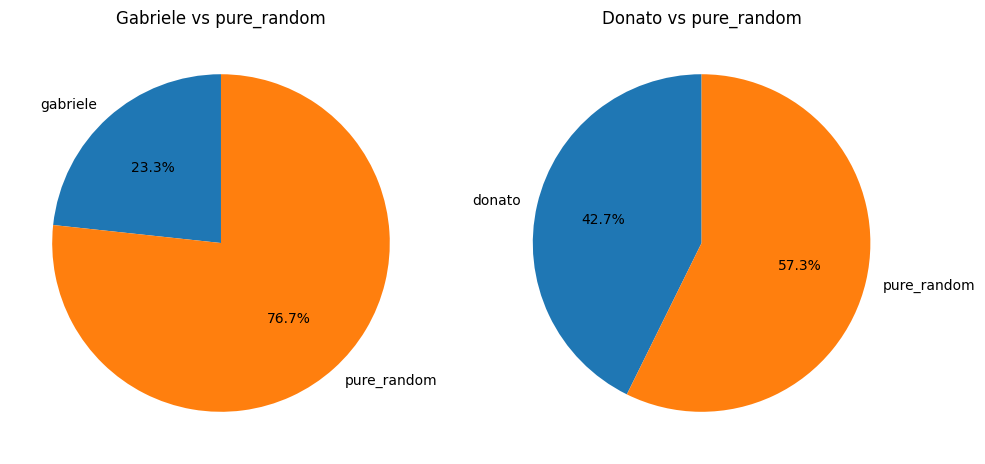

In [61]:
import matplotlib.pyplot as plt

#pie chart: gabriele vs random
labels1 = ['gabriele', 'pure_random']
sizes1 = [succ_gabriele, 1000 - succ_gabriele]

#pie chart: donato vs random
labels2 = ['donato', 'pure_random']
sizes2 = [succ_donato, 1000 - succ_donato]


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Gabriele vs pure_random')

axs[1].pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Donato vs pure_random')


plt.tight_layout()

# Display the subplot
plt.show()


Thanks to the graph it is possible to notice how the 'donato' strategy works better against a pure_random player. Even if in both cases plays pure randomly is the better choice.
The optimal is not considered for obvious reasons.

# NIM GAME EVOLUTION STRATEGY

In [62]:
def normalize(strategies: dict):
    """Needed to normalize the values of the dictionary so that they sum to one."""
    total = 0

    for v in strategies.values():
        total += v

    for k, v in strategies.items():
        # this is the actual normalization
        strategies[k] = v / total

    return strategies


def select_strategy(strategies):
    '''Select a strategy depending on the weights. Returns the index of the selected strategy.'''
    num = random.uniform(0, 1)
    cumulative_value = 0

    # for strat, prob in strategies.items():
    #     cumulative_value += prob
    #     if num < cumulative_value:
    #         return strat
        
    for ind, prob in enumerate(strategies):
        cumulative_value += prob
        if num < cumulative_value:
            return ind
    


# print(select_strategy(strategies))
# logging.getLogger().setLevel(logging.INFO)

In [63]:
def eval(strategies):
    successes = 0
    num_iter = 50
    player1_prob = [0.15, 0.2, 0.2, 0.45]
    player1_strat_index = 0
    
    for _ in range(num_iter):
        nim = Nim(5)   # initialize new game with 5 rows
        # print(f"RUN: {_}")
        # logging.info(f"init : {nim}")   # automatically calls the str
        player = 0  # starting player is assumed to be 0, remember that the starting player is disadvantaged
        if player == 1:
            player1_strat_index = select_strategy(player1_prob)
            
        while nim:  # calls the bool
            # both player know all the possible strategies
            if player == 0: 
                strategy = select_strategy(strategies) 
                #print(f"Using the strategy: {strategy}")
                if strategy == 0:
                    ply = pure_random(nim)
                elif strategy == 1:
                    ply = gabriele(nim)
                elif strategy == 2:
                    ply = donato(nim)
                elif strategy == 3:
                    ply = optimal(nim)
            else:
                if player1_strat_index == 0:
                    ply = pure_random(nim)
                elif player1_strat_index == 1:
                  ply = gabriele(nim)
                elif player1_strat_index == 2:
                    ply = donato(nim)
                elif player1_strat_index == 3:
                    ply = optimal(nim)
            
            nim.nimming(ply)    # apply the move
            
            # logging.info(f"Player {player} picks {ply}")   
            # logging.info(f"Status: {nim}")  # string with rows and numb of objects remaining
            
            player = 1 - player
            
        # logging.info(f"status: Player {player} won!")
        if player == 0:  # it means that I win (player 0)
            successes += 1
            
        # print(f"Percentage of wins by player 0: {successes/num_iter}")
    return successes / num_iter

  0%|          | 0/100 [00:00<?, ?it/s]

Best solution: {'pure_random': 0.0047931140166911105, 'gabriele': 0.0, 'donato': 0.0, 'optimal': 0.995206885983309}


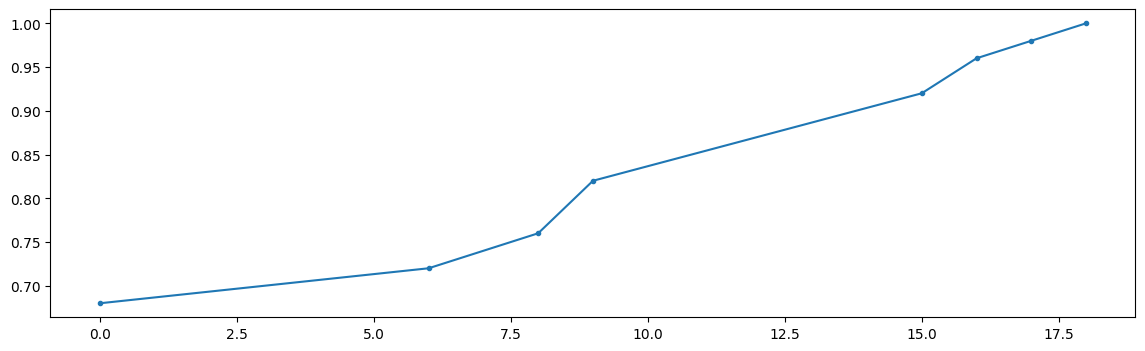

In [70]:
λ = 10  # number of offsprings
σ = 0.1  # std dev initial value
N_STRATEGIES = 4
N_DIM = N_STRATEGIES

# Initialize strategies with equal probabilities
strategies = {
    "pure_random": 0.25,
    "gabriele": 0.25,
    "donato": 0.25,
    "optimal": 0.25
}

solution = np.array(
    list(strategies.values())
)  # convert strategies to an array for processing

history = []
best_so_far = solution.copy()
best_fitness = eval(best_so_far)

for step in tqdm(range(1000 // λ)):
    offspring = (
        np.random.normal(loc=0, scale=σ, size=(λ, N_DIM)) + solution
    )  # creating new solutions
    offspring = np.clip(offspring, 0, 1)  # Ensuring probabilities stay within [0, 1]
    offspring /= offspring.sum(axis=1)[:, np.newaxis]  # normalize offspring to sum to 1

    # evaluate offspring and select the best one
    fitness = np.array([eval(s) for s in offspring])
    best_offspring = offspring[np.argmax(fitness)]
    best_offspring_fitness = np.max(fitness)

    # update the current solution if the offspring is better
    if best_offspring_fitness > best_fitness:
        best_so_far = best_offspring.copy()
        best_fitness = best_offspring_fitness
        solution = best_offspring  # Update the current solution to the new best
        history.append((step, best_fitness))

    # adapt sigma based on success rate
    success_rate = np.mean(fitness > best_fitness)
    if (step+1) % 25 == 0:
        if success_rate < 1 / 5:
            σ /= 1.1
        elif success_rate > 1 / 5:
            σ *= 1.1

# Convert the best solution back to a dictionary
best_strategy_probabilities = dict(zip(strategies.keys(), best_so_far))

# Logging the best solution
print(f"Best solution: {best_strategy_probabilities}")

# Plotting the history of best solutions

history = np.array(history)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")
plt.show()